### TODO for current general pipeline notebook
- 2D plot is not PCA when number of classes is 2
- overlay shapelets with mean class is not visible
- train with AdamW should be possible

In [1]:
# CELL 0 — Imports + global config

import os, time, random, math, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings("ignore")

# Must be set BEFORE importing keras
os.environ["KERAS_BACKEND"] = "torch"

from keras.optimizers import Adam
from keras.src.backend.torch.core import device_scope

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.decomposition import PCA

from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax, TimeSeriesScalerMeanVariance
from tslearn.shapelets import LearningShapelets, grabocka_params_to_shapelet_size_dict
from tslearn.neighbors import KNeighborsTimeSeriesClassifier

import torch

In [2]:
# CELL 1 — Repro + small utilities


def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)


def ensure_dir(p):
    p = pathlib.Path(p)
    p.mkdir(parents=True, exist_ok=True)
    return p


def cohen_d(x, y, eps=1e-12):
    x = np.asarray(x).ravel()
    y = np.asarray(y).ravel()
    nx, ny = len(x), len(y)
    if nx < 2 or ny < 2:
        return np.nan
    vx, vy = x.var(ddof=1), y.var(ddof=1)
    sp = math.sqrt(((nx - 1) * vx + (ny - 1) * vy) / max(1, (nx + ny - 2)) + eps)
    return (x.mean() - y.mean()) / sp


def standardize_ucr_name(name: str):
    aliases = {
        "Gunpoint": "GunPoint",
        "gunpoint": "GunPoint",
        "TRACE": "Trace",
        "trace": "Trace",
        "ItalyPowerDemand": "ItalyPowerDemand",
    }
    return aliases.get(name, name)

In [3]:
# CELL 1b — Notebook-level configuration (uses ensure_dir)

# Data / output
dataset_name = "GunPoint"
scaler = "minmax"
out_dir = ensure_dir("results_shapelets_ucr")

# Test subsample (keeps runtime low)
n_test_subsample = 10
subsample_seed = 0

# Sweep / training params
sweep_l = (0.05,)  # keep tiny for fast debug; expand later
sweep_r = (1,)
seeds = (0,)
max_iter = 200
lr = 1e-2
reg = 1e-2
batch_size = 16

In [4]:
# CELL 2 — Data loading + preprocessing (+ optional test subsample)


def load_ucr(dataset_name="GunPoint", scaler="minmax"):
    dataset_name = standardize_ucr_name(dataset_name)
    ucr = UCR_UEA_datasets()
    X_train, y_train, X_test, y_test = ucr.load_dataset(dataset_name)

    if scaler == "minmax":
        sc = TimeSeriesScalerMinMax()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    elif scaler == "zscore":
        sc = TimeSeriesScalerMeanVariance()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
    elif scaler in (None, "none"):
        pass
    else:
        raise ValueError(f"Unknown scaler={scaler}")

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    le = LabelEncoder()
    y_train_enc = le.fit_transform(y_train)
    y_test_enc = le.transform(y_test)

    meta = {
        "dataset": dataset_name,
        "n_train": X_train.shape[0],
        "n_test": X_test.shape[0],
        "ts_len": X_train.shape[1],
        "n_channels": X_train.shape[2],
        "n_classes": len(np.unique(y_train_enc)),
        "classes": list(le.classes_),
        "label_encoder": le,
        "scaler": scaler,
    }
    return X_train, y_train_enc, X_test, y_test_enc, meta


def subsample_test_set(X_test, y_test, n_test_subsample=10, subsample_seed=0):
    if n_test_subsample is None or n_test_subsample >= len(y_test):
        meta_sub = {
            "n_test_full": len(y_test),
            "test_subsample_indices": list(range(len(y_test))),
        }
        return X_test, y_test, meta_sub

    rng = np.random.default_rng(subsample_seed)
    classes = np.unique(y_test)

    per_class = max(1, n_test_subsample // len(classes))
    chosen = []
    for c in classes:
        idx = np.where(y_test == c)[0]
        take = min(per_class, len(idx))
        chosen.extend(rng.choice(idx, size=take, replace=False).tolist())

    chosen = np.array(sorted(set(chosen)), dtype=int)
    if len(chosen) < n_test_subsample:
        remaining = np.setdiff1d(np.arange(len(y_test)), chosen, assume_unique=False)
        extra = rng.choice(
            remaining, size=n_test_subsample - len(chosen), replace=False
        )
        chosen = np.concatenate([chosen, extra])

    rng.shuffle(chosen)

    meta_sub = {"n_test_full": len(y_test), "test_subsample_indices": chosen.tolist()}
    return X_test[chosen], y_test[chosen], meta_sub

In [5]:
# CELL 2b — Use data functions immediately (load + subsample + meta)

with device_scope("cpu"):
    X_train, y_train, X_test, y_test, meta = load_ucr(dataset_name, scaler=scaler)
    X_test, y_test, meta_sub = subsample_test_set(
        X_test, y_test, n_test_subsample=n_test_subsample, subsample_seed=subsample_seed
    )

meta["n_test_full"] = meta_sub["n_test_full"]
meta["n_test"] = len(y_test)
meta["test_subsample_indices"] = meta_sub["test_subsample_indices"]

print("=== Dataset meta ===")
for k in [
    "dataset",
    "n_train",
    "n_test",
    "ts_len",
    "n_channels",
    "n_classes",
    "scaler",
]:
    print(f"{k}: {meta[k]}")
print(f"test set subsampled: {meta['n_test']} / {meta['n_test_full']}")
print("classes:", meta["classes"])

=== Dataset meta ===
dataset: GunPoint
n_train: 50
n_test: 10
ts_len: 150
n_channels: 1
n_classes: 2
scaler: minmax
test set subsampled: 10 / 150
classes: [np.int64(1), np.int64(2)]


In [6]:
# CELL 3 — Baselines (fit once)


def fit_baselines_once(X_train, y_train, X_test, y_test):
    print("=== Baselines (fit once) ===")

    knn_euc = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="euclidean")
    knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")

    t0 = time.perf_counter()
    knn_euc.fit(X_train, y_train)
    fit_euc_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    knn_dtw.fit(X_train, y_train)
    fit_dtw_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    pred_euc = knn_euc.predict(X_test)
    pred_euc_s = time.perf_counter() - t0

    t0 = time.perf_counter()
    pred_dtw = knn_dtw.predict(X_test)
    pred_dtw_s = time.perf_counter() - t0

    baselines = pd.DataFrame(
        [
            {
                "model": "1NN-euclidean",
                "test_acc": float(accuracy_score(y_test, pred_euc)),
                "test_bal_acc": float(balanced_accuracy_score(y_test, pred_euc)),
                "test_f1_macro": float(f1_score(y_test, pred_euc, average="macro")),
                "fit_s": fit_euc_s,
                "pred_s": pred_euc_s,
            },
            {
                "model": "1NN-dtw",
                "test_acc": float(accuracy_score(y_test, pred_dtw)),
                "test_bal_acc": float(balanced_accuracy_score(y_test, pred_dtw)),
                "test_f1_macro": float(f1_score(y_test, pred_dtw, average="macro")),
                "fit_s": fit_dtw_s,
                "pred_s": pred_dtw_s,
            },
        ]
    ).sort_values("test_acc", ascending=False)

    print(baselines.to_string(index=False))
    print()

    return baselines, knn_euc, knn_dtw

In [7]:
# CELL 3b — Use baselines immediately (fit once + save)

with device_scope("cpu"):
    baselines, knn_euc, knn_dtw = fit_baselines_once(X_train, y_train, X_test, y_test)

baselines.to_csv(out_dir / f"{meta['dataset']}_baselines.csv", index=False)

=== Baselines (fit once) ===
        model  test_acc  test_bal_acc  test_f1_macro    fit_s   pred_s
1NN-euclidean       1.0           1.0            1.0 0.044926 0.009302
      1NN-dtw       0.8           0.8            0.8 0.021781 0.550129



In [8]:
# CELL 4 — Shapelet training (single run) + sweep helper


def train_eval_shapelets(
    X_train,
    y_train,
    X_test,
    y_test,
    l=0.1,
    r=1,
    lr=1e-2,
    reg=1e-2,
    batch_size=16,
    max_iter=200,
    seed=0,
    verbose=0,
):
    set_seed(seed)

    n_ts, ts_sz = X_train.shape[:2]
    n_classes = len(np.unique(y_train))

    shapelet_sizes = grabocka_params_to_shapelet_size_dict(
        n_ts=n_ts, ts_sz=ts_sz, n_classes=n_classes, l=float(l), r=int(r)
    )
    n_shapelets = int(sum(shapelet_sizes.values()))

    with device_scope("cpu"):
        clf = LearningShapelets(
            n_shapelets_per_size=shapelet_sizes,
            optimizer=Adam(lr),
            batch_size=batch_size,
            weight_regularizer=reg,
            max_iter=max_iter,
            random_state=seed,
            verbose=verbose,
        )

        t0 = time.perf_counter()
        clf.fit(X_train, y_train)
        fit_time = time.perf_counter() - t0

        t0 = time.perf_counter()
        pred_test = clf.predict(X_test)
        pred_time = time.perf_counter() - t0

        pred_train = clf.predict(X_train)

    out = {
        "model": "LearningShapelets",
        "seed": seed,
        "l": float(l),
        "r": int(r),
        "lr": float(lr),
        "reg": float(reg),
        "batch_size": int(batch_size),
        "max_iter": int(max_iter),
        "n_shapelets": n_shapelets,
        "sizes": dict(shapelet_sizes),
        "fit_s": fit_time,
        "pred_s": pred_time,
        "train_acc": float(accuracy_score(y_train, pred_train)),
        "test_acc": float(accuracy_score(y_test, pred_test)),
        "test_bal_acc": float(balanced_accuracy_score(y_test, pred_test)),
        "test_f1_macro": float(f1_score(y_test, pred_test, average="macro")),
        "n_iter_": int(getattr(clf, "n_iter_", max_iter)),
    }
    return clf, out


def run_shapelet_sweep(
    X_train,
    y_train,
    X_test,
    y_test,
    sweep_l=(0.05, 0.10, 0.15, 0.20),
    sweep_r=(1, 2, 3),
    seeds=(0, 1, 2),
    max_iter=200,
    lr=1e-2,
    reg=1e-2,
    batch_size=16,
):
    print("=== Shapelet sweep (l, r) x seeds ===")
    sweep_rows = []
    best = None
    best_key = None

    for l in sweep_l:
        for r in sweep_r:
            for seed in seeds:
                clf, row = train_eval_shapelets(
                    X_train,
                    y_train,
                    X_test,
                    y_test,
                    l=l,
                    r=r,
                    lr=lr,
                    reg=reg,
                    batch_size=batch_size,
                    max_iter=max_iter,
                    seed=seed,
                    verbose=0,
                )
                sweep_rows.append(row)
                if best is None or row["test_acc"] > best:
                    best = row["test_acc"]
                    best_key = (l, r)

    sweep_df = pd.DataFrame(sweep_rows)

    agg = (
        sweep_df.groupby(["l", "r"], as_index=False)
        .agg(
            test_acc_mean=("test_acc", "mean"),
            test_acc_std=("test_acc", "std"),
            test_bal_acc_mean=("test_bal_acc", "mean"),
            f1_macro_mean=("test_f1_macro", "mean"),
            fit_s_mean=("fit_s", "mean"),
            n_shapelets=("n_shapelets", "mean"),
        )
        .sort_values(["test_acc_mean", "test_bal_acc_mean"], ascending=False)
    )

    print("\nTop configs (mean over seeds):")
    print(agg.head(10).to_string(index=False))
    print(
        "\nBest single run:",
        {"l": best_key[0], "r": best_key[1], "best_test_acc": best},
    )

    return sweep_df, agg, best_key

In [9]:
# CELL 4b — Use training immediately (sweep + refit best + save tables)

with device_scope("cpu"):
    sweep_df, agg_df, best_key = run_shapelet_sweep(
        X_train,
        y_train,
        X_test,
        y_test,
        sweep_l=sweep_l,
        sweep_r=sweep_r,
        seeds=seeds,
        max_iter=max_iter,
        lr=lr,
        reg=reg,
        batch_size=batch_size,
    )

    best_l, best_r = best_key
    clf, best_row = train_eval_shapelets(
        X_train,
        y_train,
        X_test,
        y_test,
        l=best_l,
        r=best_r,
        lr=lr,
        reg=reg,
        batch_size=batch_size,
        max_iter=max_iter,
        seed=0,
        verbose=0,
    )

print("\n=== Best-model detailed metrics (seed=0 refit) ===")
print(pd.DataFrame([best_row]).to_string(index=False))

sweep_df.to_csv(out_dir / f"{meta['dataset']}_sweep_raw.csv", index=False)
agg_df.to_csv(out_dir / f"{meta['dataset']}_sweep_agg.csv", index=False)

=== Shapelet sweep (l, r) x seeds ===

Top configs (mean over seeds):
   l  r  test_acc_mean  test_acc_std  test_bal_acc_mean  f1_macro_mean  fit_s_mean  n_shapelets
0.05  1            0.5           NaN                0.5       0.333333   15.715187          3.0

Best single run: {'l': 0.05, 'r': 1, 'best_test_acc': 0.5}

=== Best-model detailed metrics (seed=0 refit) ===
            model  seed    l  r   lr  reg  batch_size  max_iter  n_shapelets  sizes     fit_s   pred_s  train_acc  test_acc  test_bal_acc  test_f1_macro  n_iter_
LearningShapelets     0 0.05  1 0.01 0.01          16       200            3 {7: 3} 16.026526 0.017614       0.52       0.5           0.5       0.333333      200


In [10]:
# CELL 5 — Plotting helpers (confusion + loss)


def plot_confusion(y_true, y_pred, title, savepath=None):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, colorbar=False)
    ax.set_title(title)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()


def plot_loss_curve(clf, title="Training loss", savepath=None):
    hist = getattr(clf, "history_", None)
    if hist is None or "loss" not in hist:
        print("No loss history found on clf.history_.")
        return
    losses = np.asarray(hist["loss"], dtype=float)
    fig = plt.figure(figsize=(6, 3.5))
    plt.plot(np.arange(1, len(losses) + 1), losses)
    plt.xlabel("Epoch")
    plt.ylabel("Cross-entropy")
    plt.title(title)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

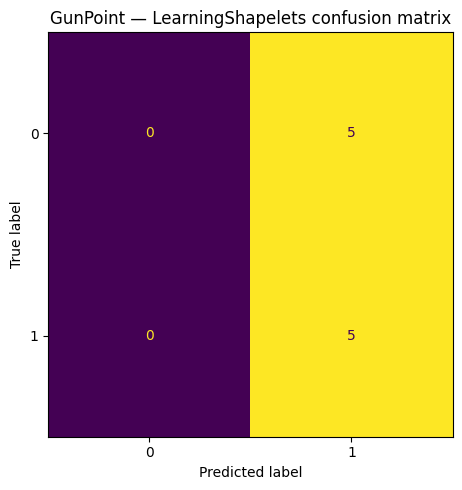

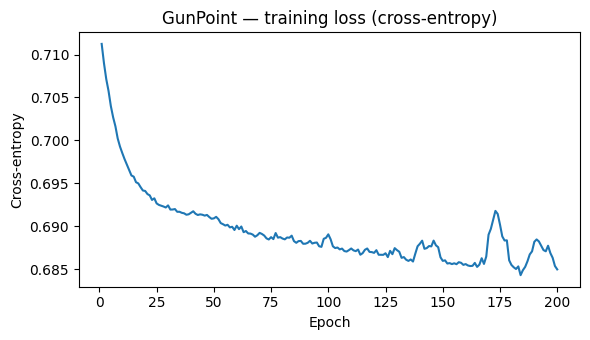

In [11]:
# CELL 5b — Use plotting helpers immediately (Plotting 1)

with device_scope("cpu"):
    y_pred = clf.predict(X_test)

plot_confusion(
    y_test,
    y_pred,
    title=f"{meta['dataset']} — LearningShapelets confusion matrix",
    savepath=out_dir / f"{meta['dataset']}_confusion.png",
)

plot_loss_curve(
    clf,
    title=f"{meta['dataset']} — training loss (cross-entropy)",
    savepath=out_dir / f"{meta['dataset']}_loss.png",
)

In [12]:
# CELL 6 — Shapelet interpretation helpers (importance + plots)


def get_classification_weights(clf):
    W, b = clf.get_weights("classification")
    return np.asarray(W), np.asarray(b)


def shapelet_importance_from_linear_head(W):
    if W.ndim == 1:
        return np.abs(W)
    return np.linalg.norm(W, axis=1)


def shapelet_effect_sizes(clf, X, y):
    D = clf.transform(X)
    classes = np.unique(y)
    eff = np.zeros(D.shape[1], dtype=float)
    for j in range(D.shape[1]):
        dj = D[:, j]
        best = 0.0
        for c in classes:
            in_c = dj[y == c]
            out_c = dj[y != c]
            d = cohen_d(in_c, out_c)
            if np.isfinite(d):
                best = max(best, abs(d))
        eff[j] = best
    return eff


def plot_top_shapelets(clf, top_idx, savepath=None):
    fig = plt.figure(figsize=(8, 1.9 * len(top_idx)))
    for k, j in enumerate(top_idx):
        ax = plt.subplot(len(top_idx), 1, k + 1)
        shp = np.asarray(clf.shapelets_[j]).ravel()
        ax.plot(shp)
        ax.set_title(f"Shapelet #{j} (length={len(shp)})")
        ax.set_xlim(0, len(shp) - 1)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()


def plot_aligned_class_means(
    clf, X, y, shapelet_idx, n_per_class=30, title=None, savepath=None
):
    shp = np.asarray(clf.shapelets_[shapelet_idx]).ravel()
    L = len(shp)
    loc = clf.locate(X)

    classes = np.unique(y)
    fig = plt.figure(figsize=(7, 2.2 * len(classes)))
    for i, c in enumerate(classes):
        ax = plt.subplot(len(classes), 1, i + 1)
        idx = np.where(y == c)[0]
        if len(idx) > n_per_class:
            idx = np.random.choice(idx, size=n_per_class, replace=False)

        segs = []
        for t in idx:
            pos = int(loc[t, shapelet_idx])
            ts = X[t].ravel()
            if pos < 0:
                continue
            if pos + L <= len(ts):
                segs.append(ts[pos : pos + L])
        segs = np.asarray(segs)
        if segs.size == 0:
            ax.set_title(f"Class {c}: no segments extracted")
            continue

        m = segs.mean(axis=0)
        s = segs.std(axis=0)
        ax.plot(m, linewidth=2, label="mean aligned segment")
        ax.fill_between(np.arange(L), m - s, m + s, alpha=0.2, label="±1 std")
        ax.plot(shp, linewidth=2, linestyle="--", label="shapelet")
        ax.set_title(
            f"Class {c}: aligned segments vs shapelet (j={shapelet_idx}, L={L})"
        )
        ax.set_xlim(0, L - 1)
        ax.legend(loc="upper right", fontsize=9)

    if title:
        fig.suptitle(title, y=1.02)
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


def plot_location_histograms(clf, X, y, shapelet_idx, bins=20, savepath=None):
    loc = clf.locate(X)
    positions = loc[:, shapelet_idx].astype(int)
    classes = np.unique(y)

    fig = plt.figure(figsize=(7, 2.2 * len(classes)))
    for i, c in enumerate(classes):
        ax = plt.subplot(len(classes), 1, i + 1)
        pos_c = positions[y == c]
        ax.hist(pos_c, bins=bins, alpha=0.8)
        ax.set_title(f"Match locations for shapelet #{shapelet_idx} in class {c}")
        ax.set_xlabel("Best-match start index")
        ax.set_ylabel("count")
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()


def plot_distance_space_pca(clf, X, y, title, savepath=None):
    D = clf.transform(X)
    Z = PCA(n_components=2, random_state=0).fit_transform(D)

    fig = plt.figure(figsize=(6, 5))
    for c in np.unique(y):
        m = y == c
        plt.scatter(Z[m, 0], Z[m, 1], edgecolors="k", alpha=0.9, label=f"class {c}")
    plt.xlabel("PC1 (distances)")
    plt.ylabel("PC2 (distances)")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

Top shapelets by linear-head importance (and effect size):
 shapelet_idx  length  importance_linear_head  separation_effect_max_abs_cohen_d
            2       7                0.561737                           1.674130
            0       7                0.091405                           1.965353
            1       7                0.017110                           0.429290


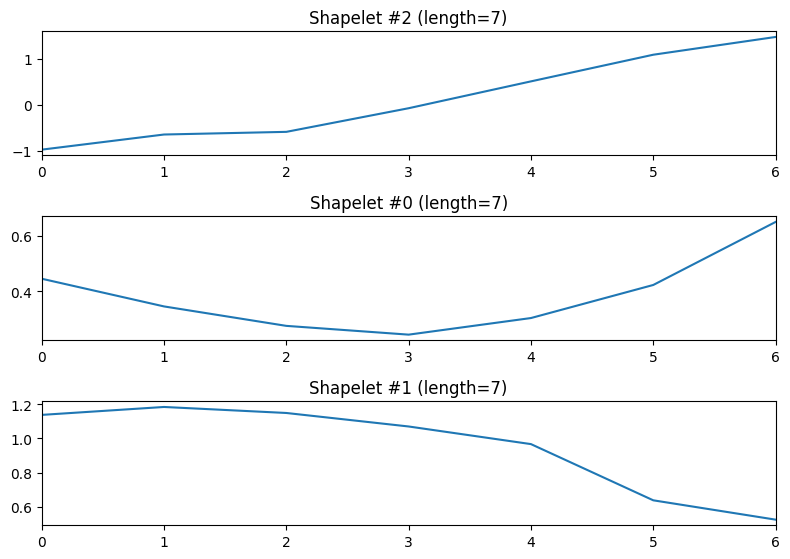

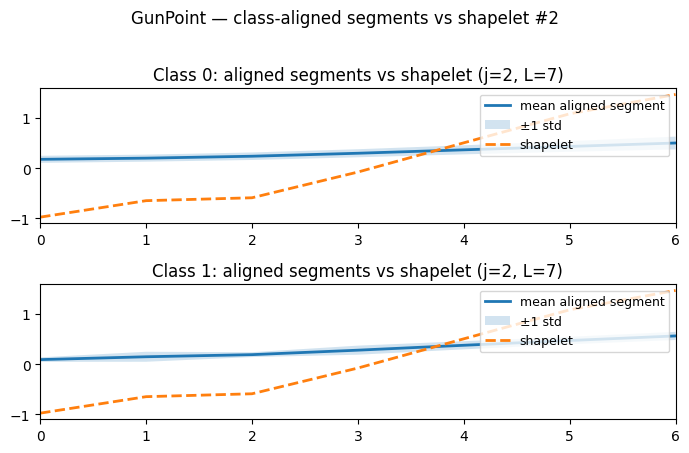

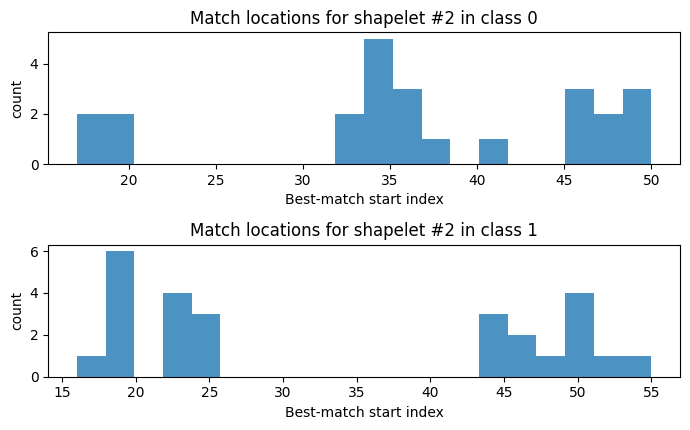

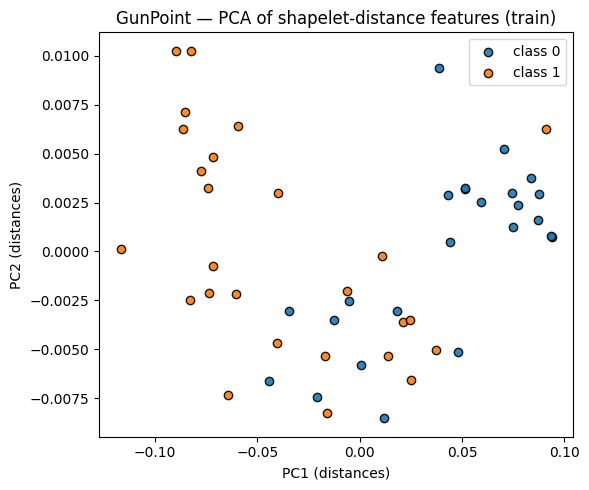

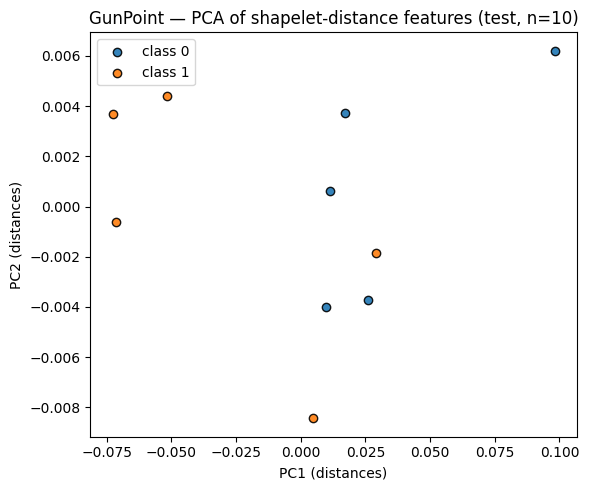

In [13]:
# CELL 6b — Use interpretation helpers immediately (Plotting 2 + Plotting 3)

with device_scope("cpu"):
    W, b = get_classification_weights(clf)

    imp_w = shapelet_importance_from_linear_head(W)
    eff = shapelet_effect_sizes(clf, X_train, y_train)

    imp_df = pd.DataFrame(
        {
            "shapelet_idx": np.arange(len(imp_w)),
            "length": [len(np.asarray(s).ravel()) for s in clf.shapelets_],
            "importance_linear_head": imp_w,
            "separation_effect_max_abs_cohen_d": eff,
        }
    ).sort_values(
        ["importance_linear_head", "separation_effect_max_abs_cohen_d"], ascending=False
    )
    imp_df.to_csv(out_dir / f"{meta['dataset']}_shapelet_importance.csv", index=False)

    print("Top shapelets by linear-head importance (and effect size):")
    print(imp_df.head(10).to_string(index=False))

    top_k = min(6, len(imp_df))
    top_idx = imp_df["shapelet_idx"].head(top_k).to_numpy()

    plot_top_shapelets(
        clf,
        top_idx,
        savepath=out_dir / f"{meta['dataset']}_top_shapelets.png",
    )

    j0 = int(top_idx[0])
    plot_aligned_class_means(
        clf,
        X_train,
        y_train,
        shapelet_idx=j0,
        title=f"{meta['dataset']} — class-aligned segments vs shapelet #{j0}",
        savepath=out_dir / f"{meta['dataset']}_aligned_means_shapelet{j0}.png",
    )

    plot_location_histograms(
        clf,
        X_train,
        y_train,
        shapelet_idx=j0,
        savepath=out_dir / f"{meta['dataset']}_locations_shapelet{j0}.png",
    )

    plot_distance_space_pca(
        clf,
        X_train,
        y_train,
        title=f"{meta['dataset']} — PCA of shapelet-distance features (train)",
        savepath=out_dir / f"{meta['dataset']}_pca_distance_train.png",
    )

    plot_distance_space_pca(
        clf,
        X_test,
        y_test,
        title=f"{meta['dataset']} — PCA of shapelet-distance features (test, n={len(y_test)})",
        savepath=out_dir / f"{meta['dataset']}_pca_distance_test.png",
    )

In [14]:
def plot_shapelet_on_best_matches(
    clf,
    X,
    y=None,
    shapelet_idx=0,
    n_examples=6,
    per_class=True,
    pick="closest",  # "closest" or "random"
    seed=0,
    rescale_shapelet="none",  # "none" or "minmax"
    show_distance_curve=False,  # optional extra panel per series
):
    """
    Plot a given shapelet overlaid on a few time series, at the index where it matches best.

    - match location is argmin over sliding windows (same as what clf.locate uses).
    - selection can be:
        * closest: pick series with smallest d(x, s_j) (most convincing matches)
        * random: random series (still aligned at their best match location)
    - per_class=True (requires y): picks ~equal count per class.
    """

    rng = np.random.default_rng(seed)

    # shapelet (flatten to 1D)
    shp = np.asarray(clf.shapelets_[shapelet_idx]).ravel()
    L = len(shp)

    # distances to all shapelets, and best-match locations
    D = clf.transform(X)  # (n_samples, n_shapelets)
    loc = clf.locate(X)  # (n_samples, n_shapelets)
    dist_j = D[:, shapelet_idx]  # (n_samples,)
    pos_j = loc[:, shapelet_idx].astype(int)

    # choose indices to plot
    if per_class and (y is not None):
        classes = np.unique(y)
        k = int(np.ceil(n_examples / len(classes)))
        chosen = []
        for c in classes:
            idx_c = np.where(y == c)[0]
            if len(idx_c) == 0:
                continue

            if pick == "closest":
                order = idx_c[np.argsort(dist_j[idx_c])]
                chosen.extend(order[: min(k, len(order))].tolist())
            elif pick == "random":
                chosen.extend(
                    rng.choice(idx_c, size=min(k, len(idx_c)), replace=False).tolist()
                )
            else:
                raise ValueError("pick must be 'closest' or 'random'")

        chosen = chosen[:n_examples]
    else:
        idx_all = np.arange(X.shape[0])
        if pick == "closest":
            chosen = idx_all[np.argsort(dist_j)][:n_examples].tolist()
        elif pick == "random":
            chosen = rng.choice(
                idx_all, size=min(n_examples, len(idx_all)), replace=False
            ).tolist()
        else:
            raise ValueError("pick must be 'closest' or 'random'")

    # optionally rescale shapelet just for visualization
    if rescale_shapelet == "minmax":
        shp_plot = TimeSeriesScalerMinMax().fit_transform(shp.reshape(1, -1, 1)).ravel()
    elif rescale_shapelet == "none":
        shp_plot = shp
    else:
        raise ValueError("rescale_shapelet must be 'none' or 'minmax'")

    # plotting
    n = len(chosen)
    ncols = 2 if show_distance_curve else 1
    fig, axes = plt.subplots(
        n, ncols, figsize=(11 if ncols == 2 else 9, 2.2 * n), squeeze=False
    )

    for row, i in enumerate(chosen):
        ts = X[i].ravel()
        pos = int(pos_j[i])

        # safety clamp
        pos = max(0, min(pos, len(ts) - L))

        # ---- left: time series + overlay ----
        ax = axes[row, 0]
        ax.plot(ts, linewidth=1.2)
        ax.axvline(pos, linestyle="--", alpha=0.35)
        ax.plot(np.arange(pos, pos + L), shp_plot, linewidth=2)

        label_str = f"idx={i}, d={dist_j[i]:.4f}"
        if y is not None:
            label_str += f", y={y[i]}"
        ax.set_title(
            f"Best match overlay ({label_str}), shapelet j={shapelet_idx}, L={L}"
        )
        ax.set_xlim(0, len(ts) - 1)

        # ---- right: distance curve (optional) ----
        if show_distance_curve:
            axd = axes[row, 1]
            # compute sliding distances to the *same* plotted shapelet version
            # (if you used rescale_shapelet='minmax', this curve is for visualization, not exactly clf's internal one)
            dcurve = []
            for t in range(len(ts) - L + 1):
                dcurve.append(np.linalg.norm(ts[t : t + L] - shp_plot))
            dcurve = np.asarray(dcurve)
            axd.plot(dcurve, linewidth=1.2)
            axd.axvline(np.argmin(dcurve), linestyle="--", alpha=0.35)
            axd.set_title("Sliding L2 distance curve")
            axd.set_xlim(0, len(dcurve) - 1)

    plt.tight_layout()
    plt.show()

    return chosen

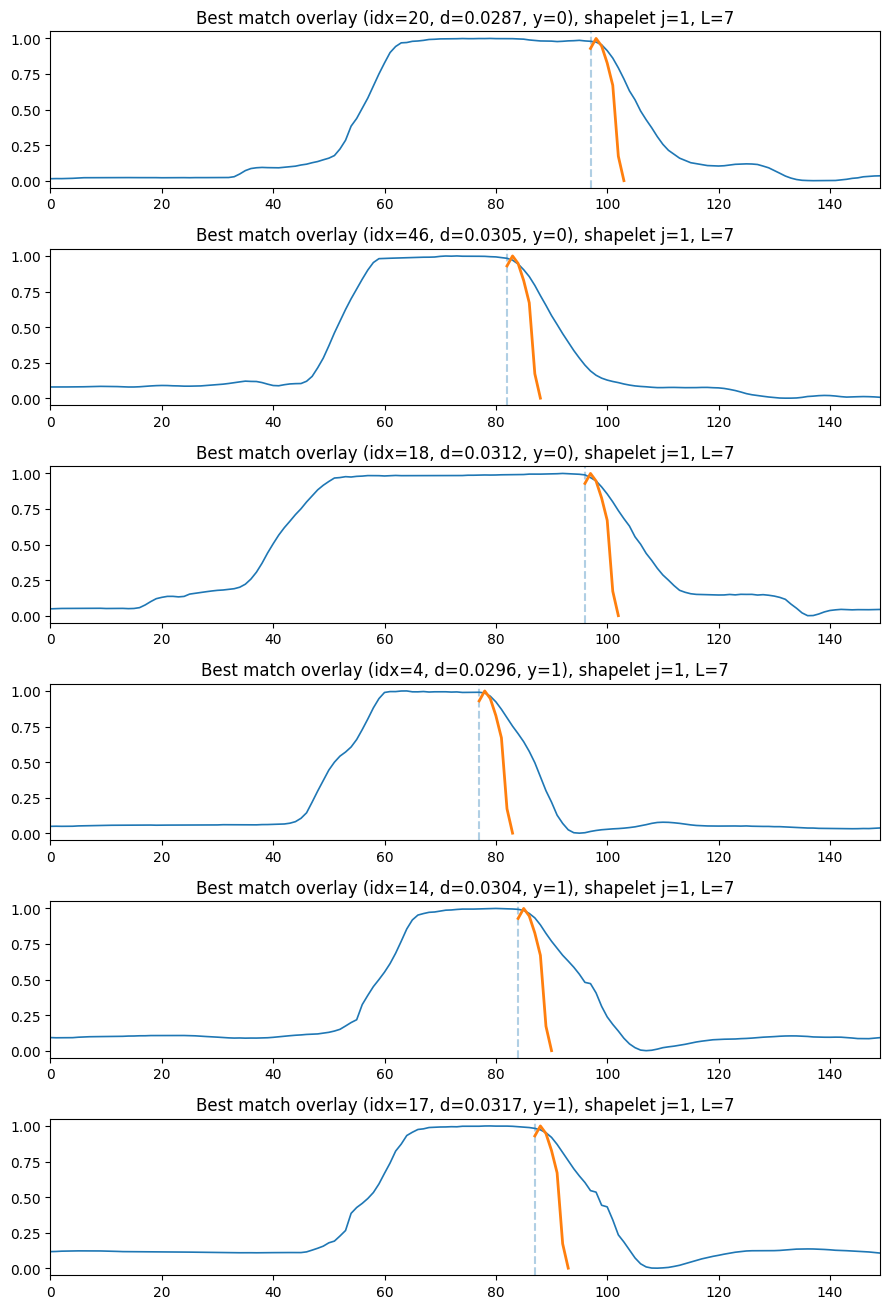

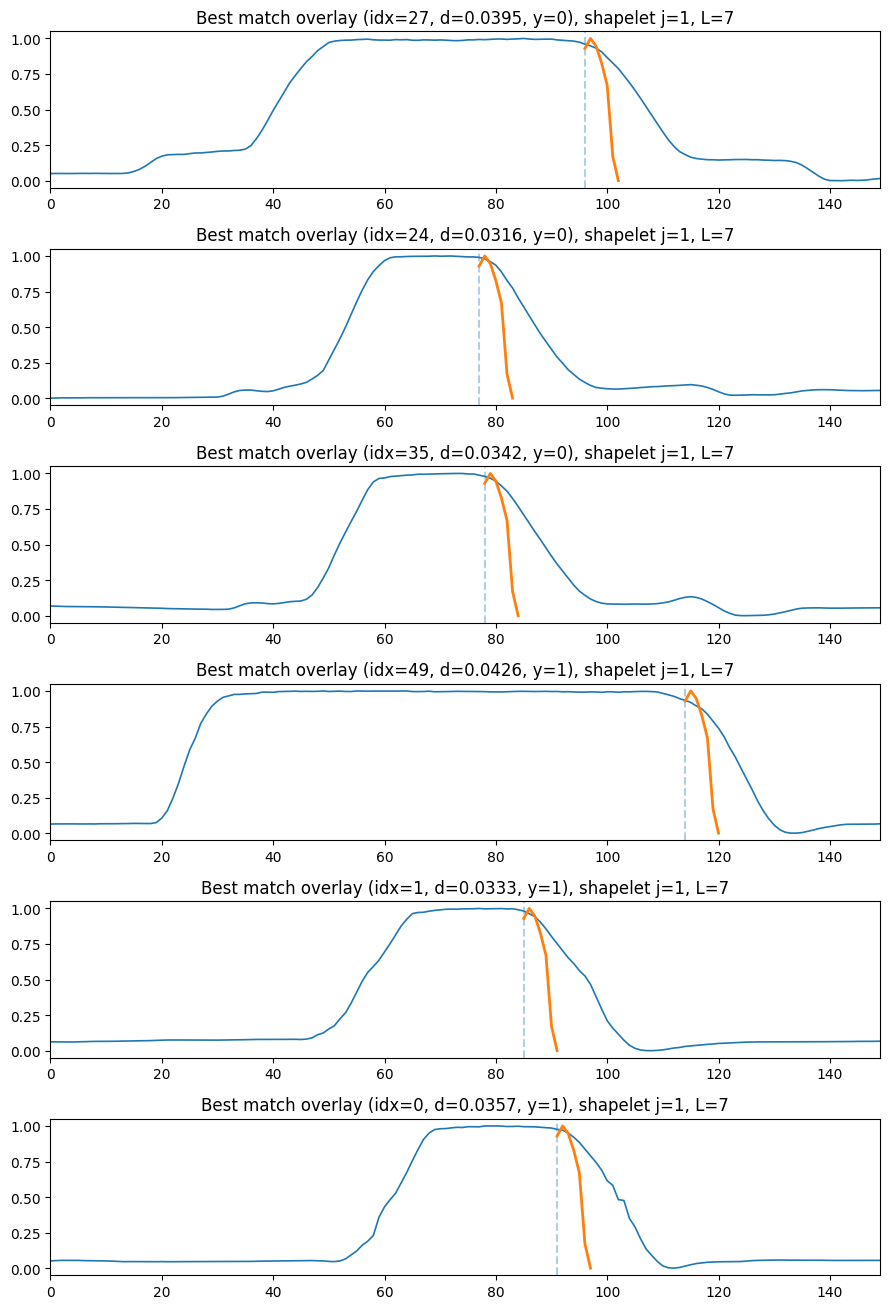

In [15]:
with device_scope("cpu"):
    # show the most convincing matches, split per class
    plot_shapelet_on_best_matches(
        clf,
        X_train,
        y=y_train,
        shapelet_idx=1,
        n_examples=6,
        per_class=True,
        pick="closest",
        rescale_shapelet="minmax",  # or "none"
        show_distance_curve=False,  # set True if you want the distance curve panel
    )

    # show random matches (still aligned), to check how universal the motif is
    plot_shapelet_on_best_matches(
        clf,
        X_train,
        y=y_train,
        shapelet_idx=1,
        n_examples=6,
        per_class=True,
        pick="random",
        seed=0,
        rescale_shapelet="minmax",
    )

In [16]:
# CELL 7 — Robustness helpers + robustness runs


def circular_shift(X, rng, max_shift=None):
    Xs = X.copy()
    T = X.shape[1]
    if max_shift is None:
        max_shift = T - 1
    for i in range(X.shape[0]):
        k = int(rng.integers(low=0, high=max_shift + 1))
        Xs[i, :, 0] = np.roll(Xs[i, :, 0], shift=k)
    return Xs


def add_gaussian_noise(X, rng, sigma_rel=0.1):
    Xn = X.copy()
    sigma = sigma_rel * float(X.std())
    Xn += rng.normal(0.0, sigma, size=X.shape).astype(X.dtype)
    return Xn


def robustness_curve(
    model_predict_fn, X_test, y_test, transforms, title, savepath=None
):
    rows = []
    for name, Xmod in transforms:
        pred = model_predict_fn(Xmod)
        rows.append(
            {
                "condition": name,
                "acc": float(accuracy_score(y_test, pred)),
                "bal_acc": float(balanced_accuracy_score(y_test, pred)),
                "f1_macro": float(f1_score(y_test, pred, average="macro")),
            }
        )
    df = pd.DataFrame(rows)

    fig = plt.figure(figsize=(7, 3.5))
    plt.plot(df["condition"], df["acc"], marker="o", label="accuracy")
    plt.plot(df["condition"], df["bal_acc"], marker="o", label="balanced acc")
    plt.ylim(0.0, 1.01)
    plt.xticks(rotation=25, ha="right")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    if savepath:
        fig.savefig(savepath, dpi=200)
    plt.show()

    return df

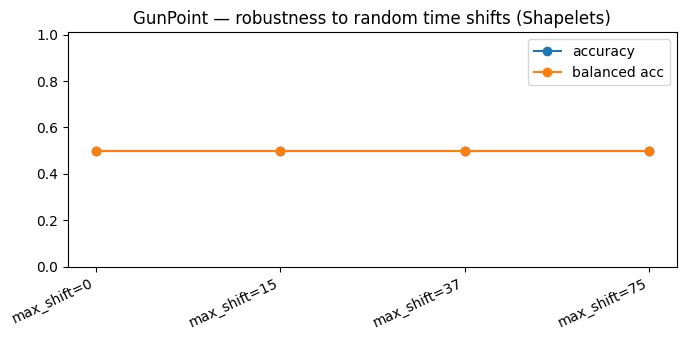

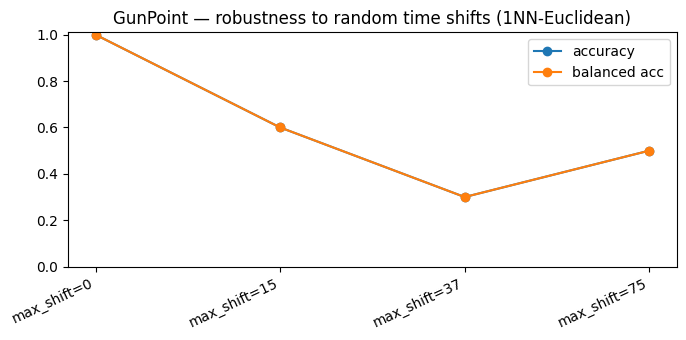

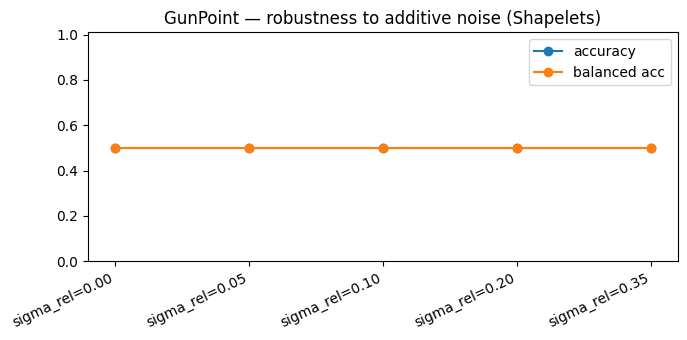

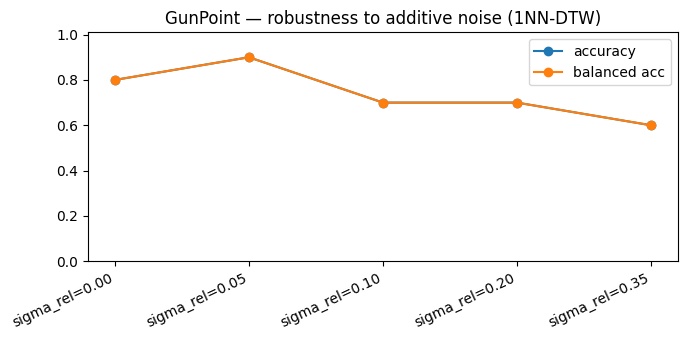

Saved robustness CSVs.


In [17]:
# CELL 7b — Use robustness helpers immediately (Plotting 4)
with device_scope("cpu"):
    # (A) Random circular shifts
    shifts = [
        0,
        int(0.1 * meta["ts_len"]),
        int(0.25 * meta["ts_len"]),
        int(0.5 * meta["ts_len"]),
    ]
    shift_transforms = []
    rng = np.random.default_rng(0)
    for s in shifts:
        Xs = X_test if s == 0 else circular_shift(X_test, rng=rng, max_shift=s)
        shift_transforms.append((f"max_shift={s}", Xs))

    df_shift_shapelets = robustness_curve(
        model_predict_fn=lambda X: clf.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=shift_transforms,
        title=f"{meta['dataset']} — robustness to random time shifts (Shapelets)",
        savepath=out_dir / f"{meta['dataset']}_robust_shift_shapelets.png",
    )

    df_shift_euc = robustness_curve(
        model_predict_fn=lambda X: knn_euc.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=shift_transforms,
        title=f"{meta['dataset']} — robustness to random time shifts (1NN-Euclidean)",
        savepath=out_dir / f"{meta['dataset']}_robust_shift_1nn_euc.png",
    )

    # (B) Additive noise
    sigmas = [0.0, 0.05, 0.10, 0.20, 0.35]
    noise_transforms = []
    rng = np.random.default_rng(0)
    for s in sigmas:
        Xn = X_test if s == 0 else add_gaussian_noise(X_test, rng=rng, sigma_rel=s)
        noise_transforms.append((f"sigma_rel={s:.2f}", Xn))

    df_noise_shapelets = robustness_curve(
        model_predict_fn=lambda X: clf.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=noise_transforms,
        title=f"{meta['dataset']} — robustness to additive noise (Shapelets)",
        savepath=out_dir / f"{meta['dataset']}_robust_noise_shapelets.png",
    )

    df_noise_dtw = robustness_curve(
        model_predict_fn=lambda X: knn_dtw.predict(X),
        X_test=X_test,
        y_test=y_test,
        transforms=noise_transforms,
        title=f"{meta['dataset']} — robustness to additive noise (1NN-DTW)",
        savepath=out_dir / f"{meta['dataset']}_robust_noise_1nn_dtw.png",
    )

    df_shift_shapelets.to_csv(
        out_dir / f"{meta['dataset']}_robust_shift_shapelets.csv", index=False
    )
    df_shift_euc.to_csv(
        out_dir / f"{meta['dataset']}_robust_shift_1nn_euc.csv", index=False
    )
    df_noise_shapelets.to_csv(
        out_dir / f"{meta['dataset']}_robust_noise_shapelets.csv", index=False
    )
    df_noise_dtw.to_csv(
        out_dir / f"{meta['dataset']}_robust_noise_1nn_dtw.csv", index=False
    )

    print("Saved robustness CSVs.")